In [1]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

#Updating settings
pd.options.display.max_columns = None

# Loading the dataset
data = pd.read_csv('./fake_job_postings_final_v2.csv')

In [2]:
data['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

Here we see that the target variable is highly imbalanced so we may need to either undersample the majority class or add class weights to each class. This will be explored later.

In [3]:
# get number of features
data.columns.nunique()

299

## Data Modelling

In [4]:
from sklearn.model_selection import StratifiedKFold, cross_validate

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# metrics
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# naive models
lr = LogisticRegression(random_state=22, max_iter=10000)
svc = LinearSVC(random_state=22, dual=False)
dt = DecisionTreeClassifier(random_state=22)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=22)
gb = GradientBoostingClassifier(random_state=22)
xgb_clf = xgb.XGBClassifier(random_state=22)

In [6]:
models=[('Logistic Regression', lr), ('Decision Tree', dt), 
        ('SVC', svc), ('Random Forest', rf), 
        ('Gradient Boosting Classifier', gb)]

Due to parameter inconsistencies I have not included KNN and XGBoost in this list. I will test them separately.

In [7]:
X = data.drop(columns=['fraudulent'])
y = data['fraudulent']

# creating class weights
sample_weight = y.copy()

for value in y.value_counts().index:
    sample_weight[y == value] = 1/y.value_counts()[value]

sample_weight = sample_weight/sample_weight.sum()

# train test split with class weights
x_train, x_test, y_train, y_test, sample_weight_train, sample_weight_test = train_test_split(X, y,
                                                                                             sample_weight, 
                                                                                             test_size = 0.3)

# initialize StratifiedKFold cross validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 22)

In [8]:
# convenience function to fit models and track performance
def model_testing(models):
    
    model_scores = []
    model_name = []
    
    # iter through model list and fit classifier
    for name, classifier in models:
        classifier.fit(x_train, y_train)
        scores = cross_validate(classifier, 
                                x_train, 
                                y_train, 
                                scoring = ['recall'], 
                                fit_params = {'sample_weight' : sample_weight_train},
                                cv = cv)
        
        model_scores.append(scores['test_recall'].mean())
        model_name.append(name)
        
    # XGBoost
    xgb_clf.fit(x_train, y_train, sample_weight=sample_weight_train)

    scores = cross_validate(xgb_clf, 
                            x_train, 
                            y_train, 
                            scoring = 'recall',
                            cv = cv)
    model_scores.append(scores['test_score'].mean())
    model_name.append('XGBoost')
    
    # KNN
    knn.fit(x_train, y_train)

    scores = cross_validate(knn, 
                            x_train, 
                            y_train, 
                            scoring = 'recall',
                            cv = cv)
    
    model_scores.append(scores['test_score'].mean())
    model_name.append('KNN')
        
    # creating dataframe summarizing mean performance across folds per model
    model_performance = pd.DataFrame({'classifier':model_name, 
                                      'mean_recall':model_scores}).sort_values(by=['mean_recall'],
                                                                              ascending=False)
    return model_performance


In [9]:
model_performance = model_testing(models)

In [10]:
model_performance

,classifier,mean_recall
4,Gradient Boosting Classifier,0.882340
1,Decision Tree,0.756417
0,Logistic Regression,0.723790
2,SVC,0.714008
3,Random Forest,0.686272
5,XGBoost,0.598134
6,KNN,0.589804


In [11]:
model_performance.set_index('classifier')

,mean_recall
classifier,
Gradient Boosting Classifier,0.882340
Decision Tree,0.756417
Logistic Regression,0.723790
SVC,0.714008
Random Forest,0.686272
XGBoost,0.598134
KNN,0.589804


We see that Gradient Boosting Classifier is the best performing model, let us check if there is a fluctuation between the recall in each fold

In [12]:
gb.fit(x_train, y_train)
scores = cross_validate(gb, 
                        x_train, 
                        y_train, 
                        scoring = ['recall'], 
                        fit_params = {'sample_weight' : sample_weight_train},
                        cv = cv)

pd.DataFrame(scores)

,fit_time,score_time,test_recall
0,1.778764,0.006782,0.869919
1,1.785567,0.006974,0.926230
2,1.779772,0.006789,0.877049
3,1.795671,0.007274,0.836066
4,1.799396,0.007025,0.902439


In [13]:
gb_scores = pd.DataFrame(scores)
gb_scores.index +=1
gb_scores = gb_scores.reset_index() \
.rename(columns={'index':'fold'}) \
.set_index('fold')

In [14]:
gb_scores

,fit_time,score_time,test_recall
fold,,,
1,1.778764,0.006782,0.869919
2,1.785567,0.006974,0.926230
3,1.779772,0.006789,0.877049
4,1.795671,0.007274,0.836066
5,1.799396,0.007025,0.902439


The recall is mostly consistent and has a high value which is most suited for our case to verify whether a job is actually fraudulent or not

In [15]:
print(classification_report(y_test, gb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5110
           1       0.89      0.35      0.50       254

    accuracy                           0.97      5364
   macro avg       0.93      0.67      0.74      5364
weighted avg       0.96      0.97      0.96      5364



We can now focus on tuning the hyperparameters for this model

## Grid Search

In [16]:
cost_benefit_matrix = np.array([[16, -3], [1, 3]])

In [18]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [1, 3, 5, 7],  
    'learning_rate' : [0.01, 0.1, 1],
    'n_estimators' : [50, 100, 200, 500]
} 

grid = GridSearchCV(gb,      
                    param_grid, 
                    scoring = 'recall',
                    cv = cv,
                   )

grid.fit(x_train, y_train, sample_weight  = sample_weight_train)

CPU times: user 19min 33s, sys: 3.72 s, total: 19min 37s
Wall time: 19min 41s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=22),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='recall')

In [19]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,1.923267,0.249378,0.009189,0.002533,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.869919,0.926230,0.877049,0.836066,0.902439,0.882340,0.030509,1
20,0.956822,0.081148,0.008014,0.002807,0.1,3,50,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.886179,0.918033,0.868852,0.844262,0.894309,0.882327,0.024754,2
22,3.729259,0.162829,0.012157,0.002557,0.1,3,200,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.861789,0.926230,0.868852,0.836066,0.910569,0.880701,0.033031,3
7,9.231096,0.444977,0.020189,0.002141,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.886179,0.918033,0.860656,0.844262,0.894309,0.880688,0.025840,4
25,2.870425,0.039655,0.009207,0.001140,0.1,5,100,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.878049,0.893443,0.877049,0.827869,0.902439,0.875770,0.025787,5
10,5.670879,0.158261,0.017540,0.003263,0.01,5,200,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.894309,0.893443,0.877049,0.811475,0.894309,0.874117,0.032005,6
19,3.364587,0.017358,0.009167,0.001133,0.1,1,500,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.837398,0.909836,0.885246,0.860656,0.869919,0.872611,0.024230,7
11,13.860073,0.051051,0.025783,0.001855,0.01,5,500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.878049,0.901639,0.868852,0.811475,0.902439,0.872491,0.033207,8
24,1.408630,0.012302,0.006488,0.000088,0.1,5,50,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.878049,0.893443,0.877049,0.811475,0.902439,0.872491,0.031970,8
33,0.670011,0.002352,0.005996,0.001211,1,1,100,"{'learning_rate': 1, 'max_depth': 1, 'n_estima...",0.845528,0.901639,0.868852,0.844262,0.878049,0.867666,0.021453,10


In [20]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [41]:
boost = GradientBoostingClassifier(
    n_estimators = 50,   
    learning_rate = 0.1,  
    max_depth = 3,        
    random_state= 22
)    

cv_results = cross_validate(boost, x_train, y_train, 
                            scoring = 'recall', 
                            cv = cv, 
                            fit_params = {'sample_weight' : sample_weight_train},
                            return_estimator = True,
                           )

cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,estimator,test_score
0,0.931969,0.008991,([DecisionTreeRegressor(criterion='friedman_ms...,0.886179
1,0.896492,0.005749,([DecisionTreeRegressor(criterion='friedman_ms...,0.918033
2,0.877933,0.009529,([DecisionTreeRegressor(criterion='friedman_ms...,0.868852
3,0.872442,0.005809,([DecisionTreeRegressor(criterion='friedman_ms...,0.844262
4,0.879785,0.005734,([DecisionTreeRegressor(criterion='friedman_ms...,0.894309


## Feature Importance

In [42]:
importances = pd.DataFrame(index = x_train.columns)

for i in cv_results.index:
    model = cv_results['estimator'][i]
    importances[i] = model.feature_importances_
    
importances['mean'] = importances.mean(axis = 1)

# looking at top 20 important features
importances.sort_values(by = 'mean', ascending = False).head(20)

,0,1,2,3,4,mean
has_company_profile,0.391627,0.405134,0.404895,0.403800,0.405479,0.402187
industry_Oil & Energy,0.101973,0.105500,0.098807,0.093087,0.095020,0.098877
required_education_High School or equivalent,0.066692,0.089431,0.076173,0.072214,0.074146,0.075731
Country_US,0.072319,0.073652,0.088023,0.060482,0.075290,0.073953
has_department,0.068088,0.056731,0.070283,0.055119,0.063994,0.062843
has_company_logo,0.055435,0.060283,0.040074,0.065113,0.055333,0.055248
Country_MY,0.028455,0.013693,0.018507,0.037259,0.026502,0.024883
required_experience_Mid-Senior level,0.022734,0.014850,0.033040,0.027880,0.020888,0.023879
function_Engineering,0.027135,0.019650,0.027922,0.019742,0.022794,0.023449
required_education_Bachelor's Degree,0.013970,0.018371,0.012701,0.019020,0.020910,0.016994


In [43]:
feature_importance = importances.sort_values(by = 'mean', ascending=False).head(20)['mean'].reset_index() \
.rename(columns={'index':'feature'})

In [44]:
feature_importance

,feature,mean
0,has_company_profile,0.402187
1,industry_Oil & Energy,0.098877
2,required_education_High School or equivalent,0.075731
3,Country_US,0.073953
4,has_department,0.062843
5,has_company_logo,0.055248
6,Country_MY,0.024883
7,required_experience_Mid-Senior level,0.023879
8,function_Engineering,0.023449
9,required_education_Bachelor's Degree,0.016994


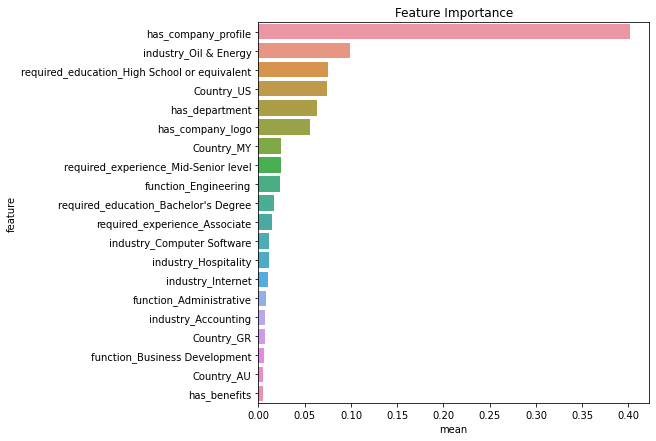

In [45]:
plt.title("Feature Importance")
sns.barplot(y='feature',
            x='mean',
            data=feature_importance,
            orient='h')
plt.show()

In [46]:
# do we keep country as a feature? Only US as a country looks significant

In [47]:
boost.fit(x_train, y_train, sample_weight=sample_weight_train)
print(classification_report(y_test, boost.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      5110
           1       0.26      0.86      0.39       254

    accuracy                           0.88      5364
   macro avg       0.62      0.87      0.66      5364
weighted avg       0.96      0.88      0.90      5364



There is a significant improvement in the recall after grid search.

Let's take a look at the confusion matrix and see what the predictions are like

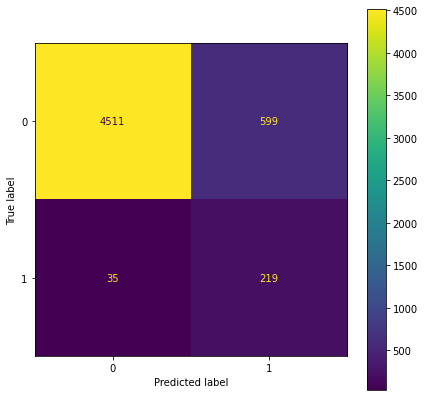

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, boost.predict(x_test), labels=boost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=boost.classes_)

plt.rcParams['figure.figsize'] = [7, 7]
disp.plot()
plt.show()

## ROC Curve

Text(0, 0.5, 'True Positive Rate')

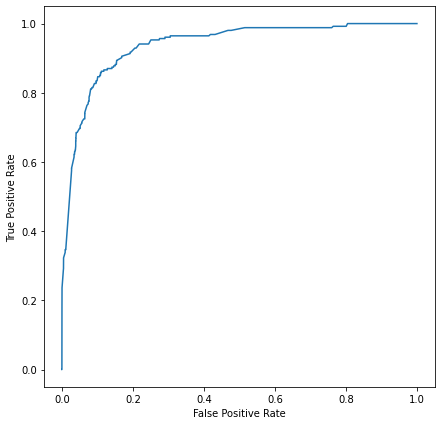

In [52]:
from sklearn.metrics import roc_curve

y_scores = boost.decision_function(x_test)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')